In [12]:
import os
import numpy as np
import pd
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split


def predict_metric_precompiled(path, target_metric, iteration, train_sizes=[], test_size=200):
    
    results_list = []
    
    test_ds = pd.read_csv(os.path.join(path, f'sub_dataset_{test_size}_test_{iteration}.csv'), delimiter=';')
    
    ignored = [
        col for col in test_ds.columns
        if col.endswith('from_ref') or col.endswith('from_mean') or col == 'cluster' or col == 'id'
    ]
    
    y_test = test_ds[target_metric]
    X_test = test_ds.drop(columns=ignored).copy()
    
    for train_size in train_sizes:
        
        train_ds = pd.read_csv(os.path.join(path, f'sub_dataset_{train_size}_train_{iteration}.csv'), delimiter=';')
        
        y_train = train_ds[target_metric]
        X_train = train_ds.drop(columns=ignored).copy()

        regressor = DecisionTreeRegressor(random_state=None, max_depth=4)
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
    
        mape = mean_absolute_percentage_error(y_test, y_pred)
    
        features = X_train.columns
        importances = regressor.feature_importances_
        feat_importances = {feat: imp for feat, imp in zip(features, importances) if imp > 0.0}
    
        # Store the decision tree as text
        tree_rules = export_graphviz(
                regressor,
                out_file=None,
                feature_names=X_train.columns.values,
                filled=True,
                rounded=True,
                special_characters=True,
                leaves_parallel=True,
                proportion=True
            )
    
        results_list.append({
            'metric': target_metric,
            'train_size': train_size,
            'MAPE': mape,
            'decision_tree': tree_rules,
            'feature_importances': feat_importances,
            'nb_features': len(feat_importances)
        })
    
    # Create a DataFrame from the results
    return pd.DataFrame(results_list)

In [37]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split


def predict_metric(dataset, target_metric, train_sizes=[], test_size=200):
    
    results_list = []
        
    train_ds, test_ds = train_test_split(dataset, test_size=test_size, random_state=None)
    ignored = [
        col for col in test_ds.columns
        if col.endswith('from_ref') or col.endswith('from_mean') or col == 'cluster' or col == 'id'
    ]
    
    y_test = test_ds[target_metric]
    X_test = test_ds.drop(columns=ignored).copy()
    
    for train_size in train_sizes:
        
        sub_train_ds, _ = train_test_split(train_ds, train_size=train_size, random_state=None)
        
        y_train = sub_train_ds[target_metric]
        X_train = sub_train_ds.drop(columns=ignored).copy()

        regressor = DecisionTreeRegressor(random_state=None, max_depth=4)
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
    
        mape = mean_absolute_percentage_error(y_test, y_pred)
    
        features = X_train.columns
        importances = regressor.feature_importances_
        feat_importances = {feat: imp for feat, imp in zip(features, importances) if imp > 0.0}
    
        # Store the decision tree as text
        tree_rules = export_graphviz(
                regressor,
                out_file=None,
                feature_names=X_train.columns.values,
                filled=True,
                rounded=True,
                special_characters=True,
                leaves_parallel=True,
                proportion=True
            )
    
        results_list.append({
            'metric': target_metric,
            'train_size': train_size,
            'MAPE': mape,
            'decision_tree': tree_rules,
            'feature_importances': feat_importances,
            'nb_features': len(feat_importances)
        })
    
    # Create a DataFrame from the results
    return pd.DataFrame(results_list)

In [39]:
import pandas as pd

corr_func = 'spearman'

metrics = [f'{corr_func}_from_ref', f'{corr_func}_from_mean']

full_regression_path_1 = os.path.join('..', 'case_study_1', 'data', 'regression', 'full')
dataset_1_path = os.path.join('..', 'case_study_1', 'data', 'normalized_dataset.csv')
dataset_1 = pd.read_csv(dataset_1_path, delimiter=';')


all_results = []

for i in range(1, 11):
    for metric in metrics:
        results_df = pd.DataFrame()
        if metric.endswith('from_mean'):
            results_df = predict_metric_precompiled(full_regression_path_1, metric, i, [80, 160, 240, 320, 400, 480, 560, 640, 720], 200)
        elif metric.endswith('from_ref'):
            results_df = predict_metric(dataset_1, metric, [80, 160, 240, 320, 400, 480, 560, 640, 720], 200)
        results_df['iteration'] = i
        all_results.append(results_df)
        
full_results_df_1 = pd.concat(all_results, ignore_index=True)

In [40]:
metrics = [f'{corr_func}_from_ref', f'{corr_func}_from_mean']

all_results = []

valid_regression_path_1 = os.path.join('..', 'case_study_1', 'data', 'regression', 'valid')
valid_df_1_path = os.path.join('..', 'case_study_1', 'data', 'valid_dataset.csv')
valid_df_1 = pd.read_csv(valid_df_1_path, delimiter=';')

for i in range(1, 11):
    for metric in metrics:
        results_df = pd.DataFrame()
        if metric.endswith('from_mean'):
            results_df = predict_metric_precompiled(valid_regression_path_1, metric, i, [60, 120, 180, 240, 300, 360, 420, 480, 540], 151)
        elif metric.endswith('from_ref'):
            results_df = predict_metric(valid_df_1, metric, [60, 120, 180, 240, 300, 360, 420, 480, 540], 151)
        results_df['iteration'] = i
        all_results.append(results_df)

valid_results_df_1 = pd.concat(all_results, ignore_index=True)

In [41]:
corr_func = 'spearman'

metrics = [f'{corr_func}_from_ref', f'{corr_func}_from_mean']

full_regression_path_2 = os.path.join('..', 'case_study_2', 'data', 'regression', 'full')
dataset_2_path = os.path.join('..', 'case_study_2', 'data', 'normalized_dataset.csv')
dataset_2 = pd.read_csv(dataset_2_path, delimiter=';')

all_results = []

for i in range(1, 11):
    for metric in metrics:
        results_df = pd.DataFrame()
        if metric.endswith('from_mean'):
            results_df = predict_metric_precompiled(full_regression_path_2, metric, i, [80, 160, 240, 320, 400, 480, 560, 640, 720], 200)
        elif metric.endswith('from_ref'):
            results_df = predict_metric(dataset_2, metric, [80, 160, 240, 320, 400, 480, 560, 640, 720], 200)
        results_df['iteration'] = i
        all_results.append(results_df)
        
full_results_df_2 = pd.concat(all_results, ignore_index=True)
dataset_2.head()

,slice_timing_correction/ref_slice/middle,distorsion_correction,signal_modeling/temporal_noise_autocorrelation/FAST,slice_timing_correction,signal_modeling/temporal_noise_autocorrelation/AR1,spatial_normalization/algorithm/linear,motion_correction_realignment/register_to/mean,signal_modeling/hrf/temporal_derivs,spatial_normalization/algorithm/DARTEL,signal_modeling/hrf/canonical,...,spatial_normalization/bias_fwhm,spatial_smoothing/fwhm,spatial_normalization/interpolation/trilinear,spatial_normalization/template/MNI305,spatial_normalization/interpolation/bspline,id,pearson_from_ref,spearman_from_ref,pearson_from_mean,spearman_from_mean
0,False,False,True,False,False,False,True,True,False,False,...,0,6,False,False,False,d73e0359ec51c3b847656b8f2bc157b083dae2057d53a4...,0.103517,0.082454,0.263128,0.245781
1,False,False,True,True,False,False,False,False,False,True,...,0,6,True,False,False,e012bd4d9bab5a18593441c76f48ccc732bca3390703ff...,0.149047,0.124797,0.337434,0.305455
2,True,False,True,True,False,False,False,True,False,False,...,0,6,True,False,False,850e4d92a370900eede8982155772f1ba014ab468eef7c...,0.956003,0.882291,0.854730,0.697912
3,False,False,True,True,False,False,False,True,False,False,...,0,6,True,False,False,84c27a9d96a41f520b1de0bf3ef88093bcf9761b45e45e...,0.724838,0.588650,0.760644,0.584104
4,False,False,True,True,False,False,True,False,False,False,...,0,6,True,False,False,0c7beba1bec8f4ff1c5ebff7e2af248230c4ce91c27775...,0.095768,0.074215,0.272972,0.252439


In [42]:
metrics = [f'{corr_func}_from_ref', f'{corr_func}_from_mean']

all_results = []

valid_regression_path_2 = os.path.join('..', 'case_study_2', 'data', 'regression', 'valid')
valid_df_2_path = os.path.join('..', 'case_study_2', 'data', 'valid_dataset.csv')
valid_df_2 = pd.read_csv(valid_df_2_path, delimiter=';')

for i in range(1, 11):
    for metric in metrics:
        results_df = pd.DataFrame()
        if metric.endswith('from_mean'):
            results_df = predict_metric_precompiled(valid_regression_path_2, metric, i, [59, 118, 178, 237, 297, 356, 415, 475, 534], 149)
        elif metric.endswith('from_ref'):
            results_df = predict_metric(valid_df_2, metric, [59, 118, 178, 237, 297, 356, 415, 475, 534], 149)
        results_df['iteration'] = i
        all_results.append(results_df)

valid_results_df_2 = pd.concat(all_results, ignore_index=True)

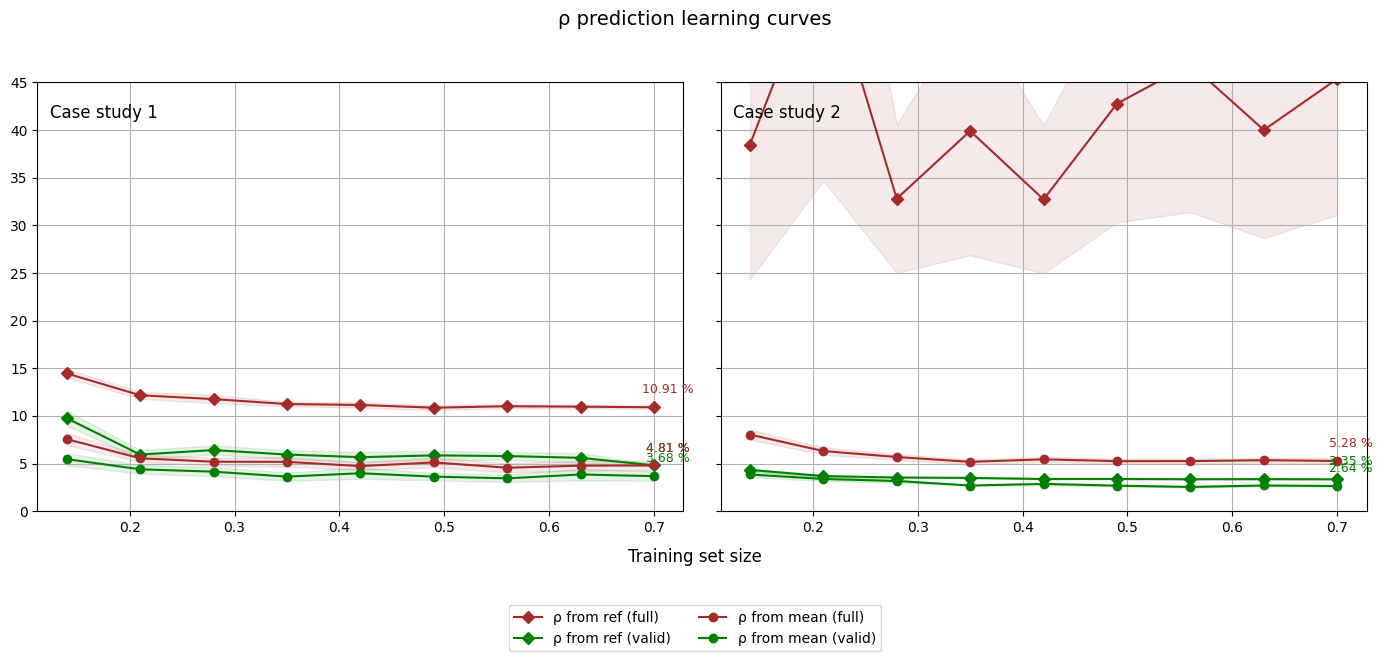

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to process data
def process_data(df):
    grouped = df.groupby(['metric', 'train_size'])['MAPE'].agg(['mean', 'std', 'count']).reset_index()
    return grouped.pivot(index='train_size', columns='metric', values=['mean', 'std', 'count'])

train_sizes = np.linspace(0.2, 1.0, 9) * 0.7

# Process data for both use cases
pivot_full_1 = process_data(full_results_df_1)
pivot_valid_1 = process_data(valid_results_df_1)
pivot_full_2 = process_data(full_results_df_2)
pivot_valid_2 = process_data(valid_results_df_2)


# Extract mean and standard error for each use case
mean_mape_ref_full_1 = pivot_full_1['mean'][f'{corr_func}_from_ref']
se_mape_ref_full_1 = pivot_full_1['std'][f'{corr_func}_from_ref'] / np.sqrt(pivot_full_1['count'][f'{corr_func}_from_ref'])
mean_mape_mean_full_1 = pivot_full_1['mean'][f'{corr_func}_from_mean']
se_mape_mean_full_1 = pivot_full_1['std'][f'{corr_func}_from_mean'] / np.sqrt(pivot_full_1['count'][f'{corr_func}_from_mean'])

mean_mape_ref_valid_1 = pivot_valid_1['mean'][f'{corr_func}_from_ref']
se_mape_ref_valid_1 = pivot_valid_1['std'][f'{corr_func}_from_ref'] / np.sqrt(pivot_valid_1['count'][f'{corr_func}_from_ref'])
mean_mape_mean_valid_1 = pivot_valid_1['mean'][f'{corr_func}_from_mean']
se_mape_mean_valid_1 = pivot_valid_1['std'][f'{corr_func}_from_mean'] / np.sqrt(pivot_valid_1['count'][f'{corr_func}_from_mean'])

mean_mape_ref_full_2 = pivot_full_2['mean'][f'{corr_func}_from_ref']
se_mape_ref_full_2 = pivot_full_2['std'][f'{corr_func}_from_ref'] / np.sqrt(pivot_full_2['count'][f'{corr_func}_from_ref'])
mean_mape_mean_full_2 = pivot_full_2['mean'][f'{corr_func}_from_mean']
se_mape_mean_full_2 = pivot_full_2['std'][f'{corr_func}_from_mean'] / np.sqrt(pivot_full_2['count'][f'{corr_func}_from_mean'])

mean_mape_ref_valid_2 = pivot_valid_2['mean'][f'{corr_func}_from_ref']
se_mape_ref_valid_2 = pivot_valid_2['std'][f'{corr_func}_from_ref'] / np.sqrt(pivot_valid_2['count'][f'{corr_func}_from_ref'])
mean_mape_mean_valid_2 = pivot_valid_2['mean'][f'{corr_func}_from_mean']
se_mape_mean_valid_2 = pivot_valid_2['std'][f'{corr_func}_from_mean'] / np.sqrt(pivot_valid_2['count'][f'{corr_func}_from_mean'])

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for use case 1
for mean, se, color, marker, dataset, metric in zip(
    [mean_mape_ref_full_1, mean_mape_ref_valid_1, mean_mape_mean_full_1, mean_mape_mean_valid_1],
    [se_mape_ref_full_1, se_mape_ref_valid_1, se_mape_mean_full_1, se_mape_mean_valid_1],
    ['brown', 'green', 'brown', 'green'],
    ['D', 'D', 'o', 'o'],
    ['full', 'valid', 'full', 'valid'],
    ['ref', 'ref', 'mean', 'mean']
):
    ax1.plot(train_sizes, mean * 100, marker=marker, color=color, linestyle='-', label=f'ρ from {metric} ({dataset})')
    ax1.fill_between(train_sizes, (mean - se) * 100, (mean + se) * 100, alpha=0.1, color=color)

# Plot for use case 2
for mean, se, color, marker, dataset, metric in zip(
    [mean_mape_ref_full_2, mean_mape_ref_valid_2, mean_mape_mean_full_2, mean_mape_mean_valid_2],
    [se_mape_ref_full_2, se_mape_ref_valid_2, se_mape_mean_full_2, se_mape_mean_valid_2],
    ['brown', 'green', 'brown', 'green'],
    ['D', 'D', 'o', 'o'],
    ['full', 'valid', 'full', 'valid'],
    ['ref', 'ref', 'mean', 'mean']
):
    ax2.plot(train_sizes, mean * 100, marker=marker, color=color, linestyle='-', label=f'ρ from {metric} ({dataset})')
    ax2.fill_between(train_sizes, (mean - se) * 100, (mean + se) * 100, alpha=0.1, color=color)

# Annotate the last point for each line in both subplots
for ax, means, ses, colors, markers, datasets, metrics in zip(
    [ax1, ax2],
    [[mean_mape_ref_full_1, mean_mape_ref_valid_1, mean_mape_mean_full_1, mean_mape_mean_valid_1],
     [mean_mape_ref_full_2, mean_mape_ref_valid_2, mean_mape_mean_full_2, mean_mape_mean_valid_2]],
    [[se_mape_ref_full_1, se_mape_ref_valid_1, se_mape_mean_full_1, se_mape_mean_valid_1],
     [se_mape_ref_full_2, se_mape_ref_valid_2, se_mape_mean_full_2, se_mape_mean_valid_2]],
    [['brown', 'green', 'brown', 'green'], ['brown', 'green', 'brown', 'green']],
    [['D', 'D', 'o', 'o'], ['D', 'D', 'o', 'o']],
    [['full', 'valid', 'full', 'valid'], ['full', 'valid', 'full', 'valid']],
    [['ref', 'ref', 'mean', 'mean'], ['ref', 'ref', 'mean', 'mean']]
):
    for mean, se, color, marker, dataset, metric in zip(means, ses, colors, markers, datasets, metrics):
        ax.annotate(
            f'{mean.iloc[-1] * 100:.2f} %',
            (train_sizes[-1], mean.iloc[-1] * 100),
            textcoords="offset points",
            xytext=(10, 10),
            ha='center',
            fontsize=9,
            color=color
        )

# Set y-axis limits and labels
for ax in [ax1, ax2]:
    ax.set_ylim(0, 45)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(True)

# Add titles and legend
fig.suptitle('ρ prediction learning curves', fontsize=14)
ax1.text(0.02, 0.95, 'Case study 1', transform=ax1.transAxes, fontsize=12, verticalalignment='top')
ax2.text(0.02, 0.95, 'Case study 2', transform=ax2.transAxes, fontsize=12, verticalalignment='top')

# Add a single x-axis label above the legend
fig.text(0.5, 0.06, 'Training set size', ha='center', fontsize=12)

# Create a common legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.savefig('regression_learning_curve.svg', format='svg', bbox_inches='tight')
plt.show()

In [19]:
def compile_and_generate_latex(iterations):
    """
    Compile mean, min, max for each feature across iterations,
    order by mean importance, and generate a LaTeX table.

    Args:
        iterations (list of dict): List of dictionaries, each representing an iteration.
    Returns:
        str: LaTeX code for the table.
    """
    # Initialize a dictionary to hold compiled data
    compiled = {}

    # Iterate over each iteration
    for iteration in iterations:
        for feature, (importance, _, _) in iteration.items():
            if feature not in compiled:
                compiled[feature] = {"values": []}
            compiled[feature]["values"].append(importance)

    # Calculate mean, min, max for each feature
    for feature in compiled:
        values = compiled[feature]["values"]
        compiled[feature]["mean"] = sum(values) / len(values)
        compiled[feature]["min"] = min(values)
        compiled[feature]["max"] = max(values)

    # Sort features by mean importance (descending)
    sorted_features = sorted(
        compiled.items(),
        key=lambda x: x[1]["mean"],
        reverse=True
    )

    # Generate LaTeX table
    latex_code = r"""
\begin{table}
  \caption{Feature importances (correlations to average statistic maps)}
  \label{tab:from_mean}
  \begin{tabular}{ccl}
\toprule
\textbf{Feature} & \textbf{Importance [min-max]} \\
\midrule
"""

    for feature, data in sorted_features:
        mean = round(data["mean"], 1)
        min_val = round(data["min"], 1)
        max_val = round(data["max"], 1)
        latex_code += f"{feature} & {mean}\% [{min_val}-{max_val}]\\\\\n"

    latex_code += r"""
  \bottomrule
\end{tabular}
\end{table}
"""
    return latex_code

<>:50: SyntaxWarning: invalid escape sequence '\%'
<>:50: SyntaxWarning: invalid escape sequence '\%'
/home/ymerel/tmp/ipykernel_9720/3458708490.py:50: SyntaxWarning: invalid escape sequence '\%'
  latex_code += f"{feature} & {mean}\% [{min_val}-{max_val}]\\\\\n"


In [20]:

# Example usage:
iterations = full_results_df_1

latex_table = compile_and_generate_latex(iterations)
print(latex_table)

AttributeError: 'str' object has no attribute 'items'